# Analysis of Energy Data
## Standard imports

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

## Import [data](https://github.com/LuisM78/Appliances-energy-prediction-data)

In [11]:
data = pd.read_csv("data/energydata_complete.csv")
data['date'] = pd.to_datetime(data['date'])
data.index = data['date']

## Recreate "seconds from midnight" data column calculated from date field with help from [here](https://stackoverflow.com/a/41252517)

In [12]:
def secsFromDT (row):
    time = str(row[0].time())
    return sum(x * int(t) for x, t in zip([3600, 60, 1], time.split(":")))
data['NSM'] = data.apply(secsFromDT, axis=1)
del data['date']

## Recreating graphs from the [paper](http://dx.doi.org/10.1016/j.enbuild.2017.01.083)

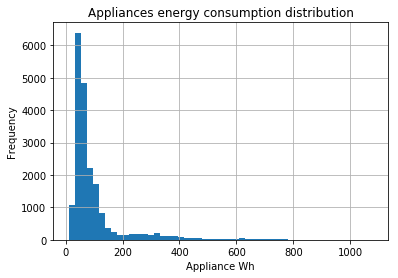

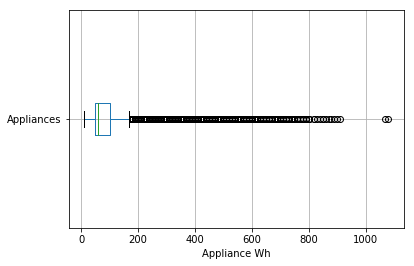

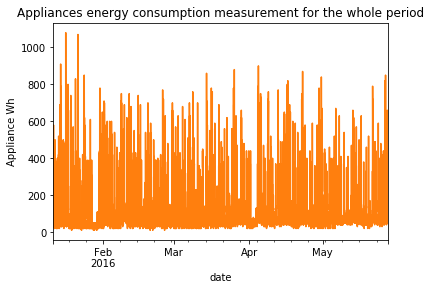

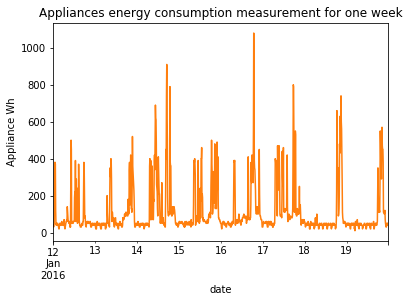

In [17]:
fig = data.hist(column='Appliances', bins=50)
plt.title("Appliances energy consumption distribution")
plt.xlabel("Appliance Wh")
plt.ylabel("Frequency")
plt.show()

fig = data.boxplot(column='Appliances', vert=False)
plt.xlabel("Appliance Wh")
plt.show()

series = pd.DataFrame(data, columns = ['date', 'Appliances'])
series.plot().get_legend().remove()
plt.title("Appliances energy consumption measurement for the whole period")
plt.ylabel("Appliance Wh")
plt.show()

series = series['1/12/2016':'1/19/2016']

series.plot().get_legend().remove()
plt.title("Appliances energy consumption measurement for one week")
plt.ylabel("Appliance Wh")
plt.show()

## Run linear regression on all fields
Our result is roughly RMSE: 92, R^2: 0.17  
Compared to the [paper](http://dx.doi.org/10.1016/j.enbuild.2017.01.083)'s result of RMSE: 94, R^2: 0.18

In [98]:
# Load all fields but Appliances and test against Appliances
X, y = [data.iloc[:, 1:], data.Appliances]

# Save 75% of data for training, 25% for testing
X_txplit(X, y, test_size=0.25)

# Train model and use to predict on our test data
reg = LinearRegression()
model = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Compute the root-mean-square-error and root-mean-square
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2:", r2_score(y_test, y_pred))

RMSE: 95.1658137458819
R^2: 0.16999258490857394


## Recursive feature elimination

In [5]:
# Using the same data as before, use an RFE to find the top 5 predictors
estimator = LinearRegression()
selector = RFE(estimator, 5)
selector = selector.fit(X, y)

# Test the model
support = selector.get_support()
predicted = selector.predict(X)
print("RMSE:", np.sqrt(mean_squared_error(y, predicted)))
print("R^2:", r2_score(y, predicted), "\n")

# Print the top 5 features and respective coefficent
d = dict(zip([*data.columns[1:][support]], np.absolute(selector.estimator_.coef_)))
for i, field in enumerate(sorted(d, key=d.get, reverse=True)):
    print(str(i+1) + ":\t" + field.ljust(12) + str(round(d[field],2)))

RMSE: 97.77802046101625
R^2: 0.09040961783537804 

1:	T3          24.67
2:	T2          18.61
3:	RH_2        17.77
4:	RH_1        16.9
5:	T9          9.83


## Discussion
We were able to recreate the results of the paper with a negligable margin of difference.  
The only noteable difference was that the top 5 features extracted in the paper were:

1. NSM
2. Lights
3. Press
4. RHS
5. T3

Whereas I came up with:

1. T3
2. T2
3. RH_2
4. RH_1
5. T9

We come to the same conclusion, in which, using a network of temperature/humidity sensors accompanied with weather data, the energy usage of appliances can be predicted from data-driven models.